In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

import sys
sys.path.append("..")
from src.datasets_labeled import labeled_datasets
from src.ETL.constants import LAT, LON, SUBSET, CROP_PROB

# Load Tigray maps

In [2]:
root = "/Users/hkerner/data/fewsnet/tigray"

b_path = f"{root}/tigray_boundary/eth_admbnda_adm1_csa_bofed_20201008.shp"

Seths = {
    "2020_1": f"{root}/seth_maps/tigray_JanSep_2020_0pt35t_nov17a_binaryyNt-003.tif", 
    "2020_2": f"{root}/seth_maps/tigray_JanSep_2020_0pt35t_nov17a_binaryySEt.tif",  
    "2021_1": f"{root}/seth_maps/tigray_JanSep_2021_0pt35t_nov17a_binaryyNt-006.tif", 
    "2021_2": f"{root}/seth_maps/tigray_JanSep_2021_0pt35t_nov17a_binaryySEt.tif"   
}

ours = {
    "2020_v2": f"{root}/tigray_maps/Ethiopia_Tigray_2020_v2.tiff",
    "2021_v2": f"{root}/tigray_maps/Ethiopia_Tigray_2021_v2.tiff"
}

In [3]:
Seths_tifs = {k: rio.open(p) for k,p in Seths.items()}
our_tifs = {k: rio.open(p) for k,p in ours.items()}

# Load labels

In [4]:
df_2020 = [d for d in labeled_datasets if d.dataset == "Ethiopia_Tigray_2020"][0].load_labels(allow_processing=False)
df_2021 = [d for d in labeled_datasets if d.dataset == "Ethiopia_Tigray_2021"][0].load_labels(allow_processing=False)

# Filter out points not inside map

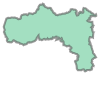

In [5]:
# Get shapefile
boundaries = gpd.read_file(b_path)
tigray_boundary = boundaries.iloc[0].geometry
tigray_boundary

In [6]:
def in_map(gdf):
    return gdf.geometry.apply(lambda x: tigray_boundary.contains(x))

In [7]:
gdf_2020 = gpd.GeoDataFrame(df_2020, geometry=gpd.points_from_xy(x=df_2020.lon, y=df_2020.lat))
gdf_2020 = gdf_2020[in_map(gdf_2020)]

In [8]:
gdf_2021 = gpd.GeoDataFrame(df_2021, geometry=gpd.points_from_xy(x=df_2021.lon, y=df_2021.lat))
gdf_2021 = gdf_2021[in_map(gdf_2021)]

In [9]:
gdf_2020["is_crop"] = (gdf_2020[CROP_PROB] > 0.5).astype(float)
gdf_2021["is_crop"] = (gdf_2021[CROP_PROB] > 0.5).astype(float)

In [10]:
def plot_set(gdf, title):
    fig, ax = plt.subplots(1, figsize=(15,15))
    boundaries.plot(ax=ax, color="lightgray")
    crop = gdf[gdf["is_crop"] == 1.0]
    non_crop = gdf[gdf["is_crop"] == 0.0]
    total = len(crop) + len(non_crop)
    non_crop.plot(ax=ax, color="yellow", label=f"Non-crop: {len(non_crop) / total:.3}")
    crop.plot(ax=ax, color="green", label=f"Crop: {len(crop) / total:.3}")
    ax.legend(loc=3, prop={'size': 15}, markerscale=2)
    ax.set_title(title, fontsize=20)
    ax.axis('off')

In [11]:
def print_metrics(actual, preds, title):
    print("---------------------------------------------------")
    print(title)
    print("---------------------------------------------------")
    print(f"F1-Score:\t{f1_score(actual, preds):.3}")
    print(f"Precision:\t{precision_score(actual, preds):.3}")
    print(f"Recall: \t{recall_score(actual, preds):.3}")
    print(f"Accuracy:\t{accuracy_score(actual, preds):.3}")

# Predictions on validation set

---------------------------------------------------
2020 Our predictions on validation set
---------------------------------------------------
F1-Score:	0.679
Precision:	0.625
Recall: 	0.743
Accuracy:	0.785
---------------------------------------------------
2020 Seth's predictions on our validation set
---------------------------------------------------
F1-Score:	0.649
Precision:	0.636
Recall: 	0.662
Accuracy:	0.781


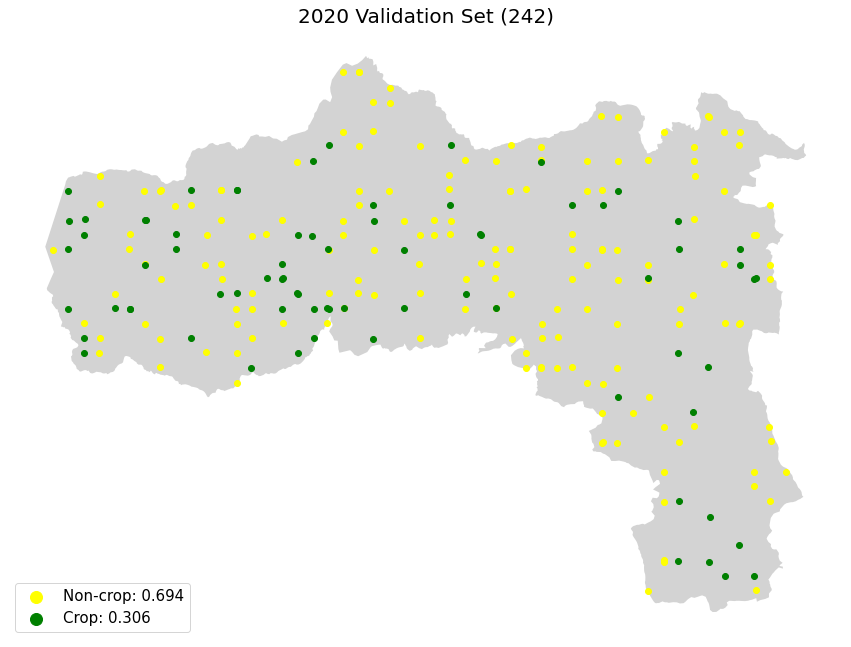

In [12]:
# Verify predictions on validation set:
gdf_2020_val = gdf_2020[(gdf_2020[SUBSET] == "validation")].copy()

preds = gdf_2020_val.geometry.apply(lambda p: next(our_tifs["2020_v2"].sample([(p.x, p.y)]))[0] > 0.5)
print_metrics(gdf_2020_val["is_crop"], preds, "2020 Our predictions on validation set")

# All hold out 2021 data is in validation set so have to test Seth's data here too
Seth_preds = gdf_2020_val.geometry.apply(lambda p: next(Seths_tifs["2020_1"].sample([(p.x, p.y)]))[0] or next(Seths_tifs["2020_2"].sample([(p.x, p.y)]))[0])
print_metrics(gdf_2020_val["is_crop"], Seth_preds, "2020 Seth's predictions on our validation set")
plot_set(gdf_2020_val, title=f"2020 Validation Set ({len(gdf_2020_val)})")

---------------------------------------------------
2021 our predictions on validation set
---------------------------------------------------
F1-Score:	0.603
Precision:	0.456
Recall: 	0.893
Accuracy:	0.588
---------------------------------------------------
2021 Seth's predictions on validation set
---------------------------------------------------
F1-Score:	0.701
Precision:	0.726
Recall: 	0.678
Accuracy:	0.797


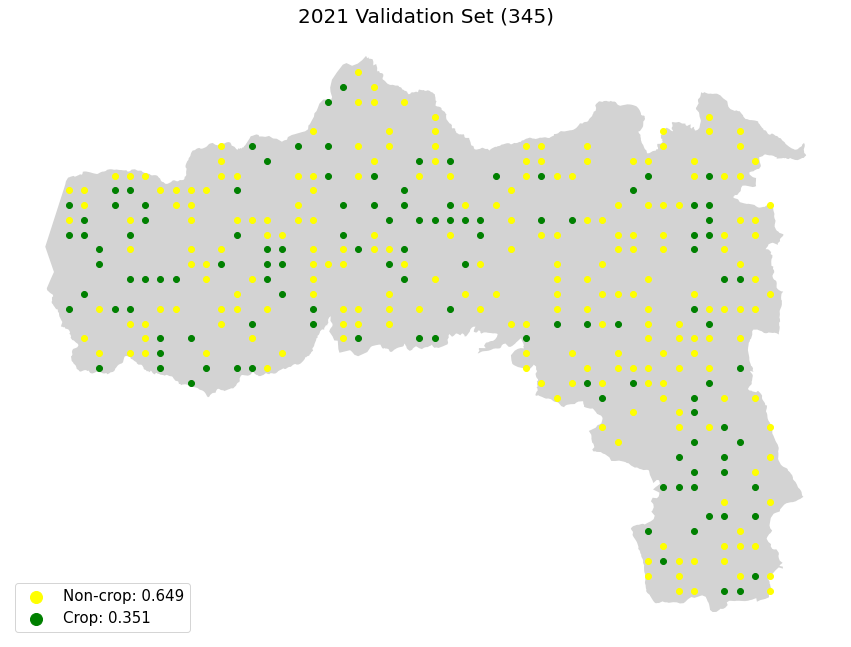

In [13]:
gdf_2021_val = gdf_2021[(gdf_2021[SUBSET] == "validation")].copy()

preds = gdf_2021_val.geometry.apply(lambda p: next(our_tifs["2021_v2"].sample([(p.x, p.y)]))[0] > 0.5)
print_metrics(gdf_2021_val["is_crop"], preds, "2021 our predictions on validation set")

# All hold out 2021 data is in validation set so have to test Seth's data here too
Seth_preds = gdf_2021_val.geometry.apply(lambda p: next(Seths_tifs["2021_1"].sample([(p.x, p.y)]))[0] or next(Seths_tifs["2021_2"].sample([(p.x, p.y)]))[0])
print_metrics(gdf_2021_val["is_crop"], Seth_preds, "2021 Seth's predictions on validation set")

plot_set(gdf_2021_val, title=f"2021 Validation Set ({len(gdf_2021_val)})")

# Predictions on small test set (only available for 2020)

---------------------------------------------------
2020 Our predictions on our test set
---------------------------------------------------
F1-Score:	0.577
Precision:	0.542
Recall: 	0.616
Accuracy:	0.719
---------------------------------------------------
2020 Seth's predictions on our test set
---------------------------------------------------
F1-Score:	0.618
Precision:	0.667
Recall: 	0.575
Accuracy:	0.779


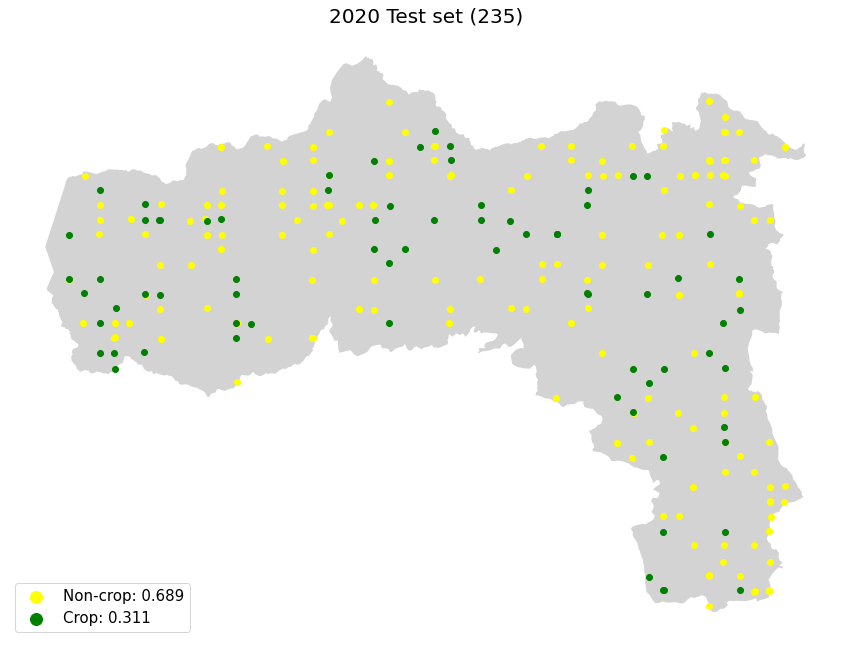

In [14]:
gdf_2020_test = gdf_2020[(gdf_2020[SUBSET] == "testing")].copy()

our_preds = gdf_2020_test.geometry.apply(lambda p: next(our_tifs["2020_v2"].sample([(p.x, p.y)]))[0] > 0.5)
print_metrics(gdf_2020_test["is_crop"], our_preds, title="2020 Our predictions on our test set")

Seth_preds = gdf_2020_test.geometry.apply(lambda p: next(Seths_tifs["2020_1"].sample([(p.x, p.y)]))[0] or next(Seths_tifs["2020_2"].sample([(p.x, p.y)]))[0])
print_metrics(gdf_2020_test["is_crop"], Seth_preds, title="2020 Seth's predictions on our test set")

plot_set(gdf_2020_test, f"2020 Test set ({len(gdf_2020_test)})")

# Predictions on reference samples (change labels)

In [15]:
ceo_set1 = pd.read_csv(f'{root}/tigray_labels/ceo/ceo-Tigray-2020-2021-Change-(set-1)-sample-data-2022-01-28.csv')

In [16]:
ceo_set2 = pd.read_csv(f'{root}/tigray_labels/ceo/ceo-Tigray-2020-2021-Change-(set-2)-sample-data-2022-01-28.csv')

In [17]:
ceo_set1['Change class'] = None
ceo_set2['Change class'] = None

In [18]:
for r, row in ceo_set1.iterrows():
    label_2020 = row['Was this a planted crop in 2020?']
    label_2021 = row['Was this a planted crop in 2021?']
    if label_2020 == 'Not planted' and label_2021 == 'Not planted':
        ceo_set1.loc[r,'Change class'] = 0
    elif label_2020 == 'Not planted' and label_2021 == 'Planted':
        ceo_set1.loc[r,'Change class'] = 1
    elif label_2020 == 'Planted' and label_2021 == 'Not planted':
        ceo_set1.loc[r,'Change class'] = 2
    elif label_2020 == 'Planted' and label_2021 == 'Planted':
        ceo_set1.loc[r,'Change class'] = 3

In [19]:
for r, row in ceo_set2.iterrows():
    label_2020 = row['Was this a planted crop in 2020?']
    label_2021 = row['Was this a planted crop in 2021?']
    if label_2020 == 'Not planted' and label_2021 == 'Not planted':
        ceo_set2.loc[r,'Change class'] = 0
    elif label_2020 == 'Not planted' and label_2021 == 'Planted':
        ceo_set2.loc[r,'Change class'] = 1
    elif label_2020 == 'Planted' and label_2021 == 'Not planted':
        ceo_set2.loc[r,'Change class'] = 2
    elif label_2020 == 'Planted' and label_2021 == 'Planted':
        ceo_set2.loc[r,'Change class'] = 3

In [20]:
print("Number of points with non-consensus labels:", 
      ceo_set2[ceo_set1['Change class'] != ceo_set2['Change class']].shape[0])

Number of points with non-consensus labels: 0


In [21]:
ref_labels = gpd.GeoDataFrame(ceo_set1, geometry=gpd.points_from_xy(x=ceo_set1.lon, y=ceo_set1.lat))

<AxesSubplot:>

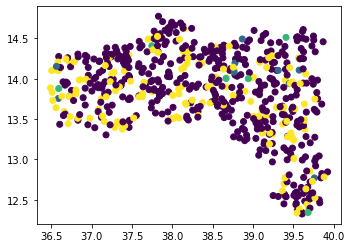

In [22]:
ref_labels.plot(c=ref_labels['Change class'])

In [23]:
for r, row in ref_labels.iterrows():
    # Get our change prediction
    our_2020 = next(our_tifs["2020_v2"].sample([(row.geometry.x, row.geometry.y)]))[0] > 0.5
    our_2021 = next(our_tifs["2021_v2"].sample([(row.geometry.x, row.geometry.y)]))[0] > 0.5
    if our_2020 == 0 and our_2021 == 0:
        ref_labels.loc[r, 'Our pred'] = 0
    elif our_2020 == 0 and our_2021 == 1:
        ref_labels.loc[r, 'Our pred'] = 1
    elif our_2020 == 1 and our_2021 == 0:
        ref_labels.loc[r, 'Our pred'] = 2
    elif our_2020 == 1 and our_2021 == 1:
        ref_labels.loc[r, 'Our pred'] = 3
        
    # Get Seth's change prediction
    seth_2020 = (next(Seths_tifs["2020_1"].sample([(row.geometry.x, row.geometry.y)]))[0] or next(Seths_tifs["2020_2"].sample([(row.geometry.x, row.geometry.y)]))[0])
    seth_2021 = (next(Seths_tifs["2021_1"].sample([(row.geometry.x, row.geometry.y)]))[0] or next(Seths_tifs["2021_2"].sample([(row.geometry.x, row.geometry.y)]))[0])
    if seth_2020 == 0 and seth_2021 == 0:
        ref_labels.loc[r, 'Seth pred'] = 0
    elif seth_2020 == 0 and seth_2021 == 1:
        ref_labels.loc[r, 'Seth pred'] = 1
    elif seth_2020 == 1 and seth_2021 == 0:
        ref_labels.loc[r, 'Seth pred'] = 2
    elif seth_2020 == 1 and seth_2021 == 1:
        ref_labels.loc[r, 'Seth pred'] = 3

In [24]:
ref_labels

,plotid,sampleid,lon,lat,email,flagged,collection_time,analysis_duration,imagery_title,imagery_attributions,sample_geom,pl_sampleid,Was this a planted crop in 2020?,Was this a planted crop in 2021?,Change class,geometry,Our pred,Seth pred
0,0,0,38.044465,14.466000,hkerner@umd.edu,False,2021-11-17 15:37,216.4 secs,Planet Monthly Mosaics,NaN,POINT(38.04446549084796 14.46600000567765),0,Not planted,Not planted,0,POINT (38.04447 14.46600),2.0,2.0
1,1,1,37.699107,14.490831,hkerner@umd.edu,False,2021-11-21 08:57,14.5 secs,Planet Monthly Mosaics,NaN,POINT(37.699106684514234 14.490830516370108),1,Planted,Planted,3,POINT (37.69911 14.49083),0.0,2.0
2,2,2,39.751425,14.478674,hkerner@umd.edu,False,2021-11-17 15:45,191.5 secs,Planet Monthly Mosaics,NaN,POINT(39.75142468697266 14.478674222387781),2,Not planted,Not planted,0,POINT (39.75142 14.47867),0.0,0.0
3,3,3,38.113275,14.119644,hkerner@umd.edu,False,2021-11-17 15:47,71.2 secs,Planet Monthly Mosaics,NaN,POINT(38.113274682684654 14.119644281322522),3,Planted,Planted,3,POINT (38.11327 14.11964),3.0,3.0
4,4,4,38.768685,14.439435,hkerner@umd.edu,False,2021-11-17 15:48,51.3 secs,Planet Monthly Mosaics,NaN,POINT(38.7686845624209 14.439435434528004),4,Not planted,Not planted,0,POINT (38.76868 14.43944),0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,595,595,37.821248,14.324145,hkerner@umd.edu,False,2022-01-06 19:30,290.5 secs,Planet Monthly Mosaics,NaN,POINT(37.82124822318578 14.324144555456677),595,Planted,Planted,3,POINT (37.82125 14.32414),3.0,3.0
596,596,596,39.550264,14.520097,hkerner@umd.edu,False,2022-01-10 14:46,7.3 secs,Planet Monthly Mosaics,NaN,POINT(39.55026436692808 14.520097375963012),596,Not planted,Not planted,0,POINT (39.55026 14.52010),1.0,0.0
597,597,597,38.753236,14.143033,hkerner@umd.edu,False,2022-01-10 14:46,7.2 secs,Planet Monthly Mosaics,NaN,POINT(38.75323551997168 14.143032713731968),597,Planted,Planted,3,POINT (38.75324 14.14303),2.0,3.0
598,598,598,39.034601,13.260275,hkerner@umd.edu,False,2022-01-10 14:46,7.6 secs,Planet Monthly Mosaics,NaN,POINT(39.034600741728475 13.26027516129248),598,Not planted,Not planted,0,POINT (39.03460 13.26028),3.0,0.0


In [25]:
from sklearn.metrics import confusion_matrix

In [26]:
print('Our confusion matrix')
confusion_matrix(y_true=ref_labels['Change class'].astype(int), y_pred=ref_labels['Our pred'].astype(int))

Our confusion matrix


array([[146, 137,  71,  84],
       [  0,   2,   2,   6],
       [  0,   0,   3,   3],
       [ 10,  29,  23,  84]])

In [27]:
print('Our overall accuracy')
accuracy_score(y_true=ref_labels['Change class'].astype(int), y_pred=ref_labels['Our pred'].astype(int))

Our overall accuracy


0.39166666666666666

In [28]:
print('Seth confusion matrix')
confusion_matrix(y_true=ref_labels['Change class'].astype(int), y_pred=ref_labels['Seth pred'].astype(int))

Seth confusion matrix


array([[312,  39,  45,  42],
       [  1,   1,   1,   7],
       [  0,   0,   3,   3],
       [ 28,  19,  21,  78]])

In [29]:
print('Seth overall accuracy')
accuracy_score(y_true=ref_labels['Change class'].astype(int), y_pred=ref_labels['Seth pred'].astype(int))

Seth overall accuracy


0.6566666666666666